<a href="https://colab.research.google.com/github/DevKor-Team/MRDC-Challenge/blob/jo/Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
from __future__ import print_function
from __future__ import division

from PIL import Image

import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
# from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import itertools    # confusion matrix에서 사용

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import albumentations
import albumentations.pytorch

In [ ]:
BASE_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/data'

import os

test = pd.read_csv(os.path.join(BASE_DIR, 'Test.csv'))
test_rgb = test.loc[~test['Image_id'].str.contains('_rgn')]
test_rgb.head()

,Image_id
0,id_00vl5wvxq3.jpg
2,id_01hu05mtch.jpg
4,id_030ln10ewn.jpg
6,id_03z57m8xht.jpg
8,id_04ngep1w4b.jpg


In [ ]:
ss = pd.read_csv(os.path.join(BASE_DIR, 'SampleSubmission.csv'))
ss.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.0,0.0,0.0
1,id_01hu05mtch.jpg,0.0,0.0,0.0
2,id_030ln10ewn.jpg,0.0,0.0,0.0
3,id_03z57m8xht.jpg,0.0,0.0,0.0
4,id_04ngep1w4b.jpg,0.0,0.0,0.0


In [ ]:
def test_model(device, model, test_loader):
    test_pred_non_prob = []

    model.eval()
    model = model.to(device)
    with torch.set_grad_enabled(False):
        for features in test_loader:
            features = features.to(device)

            outputs = model(features.to(torch.float))
            test_pred_non_prob.append(outputs[0])
            # probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
            # test_pred_non_prob.append(probabilities.tolist())

    return test_pred_non_prob

In [ ]:
class Img_Dataset_with_aug(Dataset):
    def __init__(self, file_path, aug_transform, table, is_train=True, test_transform=None):
        self.file_path = file_path
        self.aug_transform = aug_transform
        self.table = table
        self.is_train = is_train
        self.test_transform = test_transform
        
        self.img_name_list = self.table['Image_id'].tolist()
        self.img_list = []

        if self.is_train:   # train -> augmentation 필요
          self.table_label_list = self.table['Label'].tolist()
          self.label_list = []
          for i, img_name in enumerate(self.img_name_list):
            img = Image.open(os.path.join(self.file_path, img_name))
            print(i)
            if self.table_label_list[i] == 'blast':
              img_transformed = self.test_transform(image=np.array(img))['image']
              self.img_list.append(img_transformed)
              self.label_list.append(0)
            elif self.table_label_list[i] == 'brown':
              for _ in range(2):   
                img_transformed = self.aug_transform(image=np.array(img))['image']
                self.img_list.append(img_transformed)
                self.label_list.append(1)
            else:
              for _ in range(4):   
                img_transformed = self.aug_transform(image=np.array(img))['image']
                self.img_list.append(img_transformed)
                self.label_list.append(2)

        else:   # test -> augmentation 필요X
            for img_name in self.img_name_list:
                img = Image.open(os.path.join(self.file_path, img_name))
                img_transformed = self.test_transform(image=np.array(img))['image']
                self.img_list.append(img_transformed)
  
    def __len__(self):
        return len(self.img_list)
  
    def __getitem__(self, index):
        if self.is_train:
            return self.img_list[index], self.label_list[index]
        else:
            return self.img_list[index]

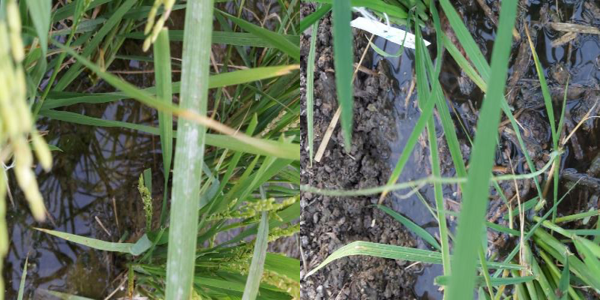

In [ ]:
out = Image.new('RGB', (600, 300))
out.paste(Image.open(os.path.join('/content/gdrive/MyDrive/ML/MRDC-competition/data/images', 'id_004wknd7qd.jpg')).resize((300, 300)), (0, 0))
out.paste(Image.open(os.path.join('/content/gdrive/MyDrive/ML/MRDC-competition/data/images', 'id_00stp9t6m6.jpg')).resize((300, 300)), (300, 0))
out

In [ ]:
def make_data_loader_with_aug(batch_size=128, size=224, split=0.8):
  IMG_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/data/images'
  test_transform=albumentations.Compose([
    albumentations.Resize(size, size),
    albumentations.Normalize(),
    albumentations.pytorch.transforms.ToTensorV2(),
  ])

  # train data
  '''
  train_dataset = Img_Dataset_with_aug(IMG_DIR, aug_transform, train_rgb, test_transform=test_transform)

  train_size = int(len(train_dataset) * split)
  val_size = len(train_dataset) - train_size

  train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)'''
  
  # test data
  test_dataset = Img_Dataset_with_aug(IMG_DIR, None, test_rgb, is_train=False, test_transform=test_transform)
  test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
  
  return test_loader

상위 3개? 5개 model 가지고 앙상블
1. ResNeXt50d (0.15)
2. ConvNeXt base 384 (0.19)
3. ResNeXt50 (torchvision ver.) (0.2)
4. convNeXt tiny (timm ver.) (0.22)
5. SEResNeXt50 (0.25)

#Model Loading

In [ ]:
MODEL_DIR = '/content/gdrive/MyDrive/ML/MRDC-competition/models'

In [ ]:
import sys
# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.5.4 

from timm import create_model

Running in Colab.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 431 kB 4.2 MB/s 


### [5위] SEResNeXt50

In [ ]:
class mySEResNeXt50(nn.Module):
  def __init__(self, num_classes):
    super(mySEResNeXt50, self).__init__()
    self.model_ft = create_model('seresnext50_32x4d', pretrained=True)
    
    num_ftrs = self.model_ft.fc.in_features
    self.model_ft.fc = nn.Linear(num_ftrs, num_classes)

  def forward(self, x):
      out = self.model_ft(x)
      return out

In [ ]:
seresnext50 = mySEResNeXt50(3)
seresnext50.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'seresnext50_aug_checkpoint.pt')))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/seresnext50_32x4d_racm-a304a460.pth" to /root/.cache/torch/hub/checkpoints/seresnext50_32x4d_racm-a304a460.pth


<All keys matched successfully>

### [4위] convNeXt tiny (timm ver.)

In [ ]:
class myConvNeXtTiny(nn.Module):
  def __init__(self, num_classes):
    super( myConvNeXtTiny, self).__init__()
    self.model_ft = create_model('convnext_tiny', pretrained=True)
    
    num_ftrs = self.model_ft.head.fc.in_features
    self.model_ft.head.fc = nn.Linear(num_ftrs, num_classes)

  def forward(self, x):
      out = self.model_ft(x)
      return out

In [ ]:
convnext_tiny = myConvNeXtTiny(3)
convnext_tiny.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'convnext_tiny_aug_checkpoint.pt')))

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_1k_224_ema.pth


<All keys matched successfully>

### [3위] ResNeXt50 (Torchvision ver.)

In [ ]:
class myResNeXt50(nn.Module):
  def __init__(self, num_classes):
    super(myResNeXt50, self).__init__()
    self.model_ft = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.DEFAULT)
    
    num_ftrs = self.model_ft.fc.in_features
    self.model_ft.fc = nn.Linear(num_ftrs, num_classes)

  def forward(self, x):
      out = self.model_ft(x)
      return out

In [ ]:
resnext50 = myResNeXt50(3)
resnext50.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'resnext50-aug_checkpoint.pt')))

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

<All keys matched successfully>

### [2위] ConvNeXt base 384

In [ ]:
class myConvNextBase384(nn.Module):
  def __init__(self, num_classes):
    super(myConvNextBase384, self).__init__()
    self.model_ft = create_model('convnext_base_384_in22ft1k', pretrained=True)
    
    num_ftrs = self.model_ft.head.fc.in_features
    self.model_ft.head.fc = nn.Linear(num_ftrs, num_classes)

  def forward(self, x):
      out = self.model_ft(x)
      return out

In [ ]:
convnext_base_384 = myConvNextBase384(3)
convnext_base_384.load_state_dict(torch.load(os.path.join(MODEL_DIR, "convnext_base_384_aug2_checkpoint.pt")))

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_base_22k_1k_384.pth" to /root/.cache/torch/hub/checkpoints/convnext_base_22k_1k_384.pth


<All keys matched successfully>

### [1위] ResNeXt50d

In [ ]:
class myResNext50d(nn.Module):
  def __init__(self, num_classes):
    super(myResNext50d, self).__init__()
    self.model_ft = create_model('resnext50d_32x4d', pretrained=True)
    
    num_ftrs = self.model_ft.fc.in_features
    self.model_ft.fc = nn.Linear(num_ftrs, num_classes)

  def forward(self, x):
      out = self.model_ft(x)
      return out

In [ ]:
resnext50d = myResNext50d(3)
resnext50d.load_state_dict(torch.load(os.path.join(MODEL_DIR, "resnext50d_aug_checkpoint.pt")))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnext50d_32x4d-103e99f8.pth" to /root/.cache/torch/hub/checkpoints/resnext50d_32x4d-103e99f8.pth


<All keys matched successfully>

# Start Ensemble !

In [ ]:
# test dl 준비
test_loader = make_data_loader_with_aug()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
models_list = [resnext50, convnext_base_384, resnext50d]  # 성능 안 좋은 순

In [ ]:
test_preds = []
for m in models_list:
  test_preds.append(test_model(device, m, test_loader))
  print(test_preds[-1][:2])

[tensor([ 7.8554, -3.4541, -4.4211], device='cuda:0'), tensor([-1.2075,  3.2363, -2.6678], device='cuda:0')]
[tensor([ 3.2393,  0.8858, -4.6091], device='cuda:0'), tensor([-1.0273,  7.4467, -6.4475], device='cuda:0')]
[tensor([ 8.3092, -7.2395, -1.8663], device='cuda:0'), tensor([-6.0613,  6.7602, -3.8236], device='cuda:0')]


In [ ]:
# weighted sum 구하기
weights = torch.Tensor([0.2, 0.3, 0.5])
'''
t = torch.Tensor([ 7.8554, -3.4541, -4.4211])
# t = [torch.Tensor([ 7.8554, -3.4541, -4.4211]), torch.Tensor([-1.2075,  3.2363, -2.6678])]  # 이렇게 할 경우 아래 식이 적용 안됨.
print(weights[2] * t) # 이렇게 하면 tensor의 스칼라배를 리턴
'''

weighted_preds = []
for i, test_pred in enumerate(test_preds):
  weighted_preds.append([])
  for tensor in test_pred:
    weighted_preds[i].append(weights[i] * tensor)

weighted_preds_sum = []
for i in range(len(weighted_preds[0])):
  weighted_preds_sum.append(weighted_preds[0][i] + weighted_preds[1][i] + weighted_preds[2][i])

In [ ]:
print(len(weighted_preds_sum))
print(weighted_preds_sum[:2])

1145
[tensor([ 6.6975, -4.0448, -3.2001], device='cuda:0'), tensor([-3.5803,  6.2614, -4.3796], device='cuda:0')]


In [ ]:
test_prob = []
for s in weighted_preds_sum:
  probabilities = torch.nn.functional.softmax(s, dim=0)
  test_prob.append(probabilities.tolist())

In [ ]:
ss.loc[:, ['blast', 'brown', 'healthy']] = test_prob
ss.to_csv("result_ensemble1.csv", index=False)
ss.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.999928,2.161069e-05,5.029393e-05
1,id_01hu05mtch.jpg,0.000053,9.999229e-01,2.391400e-05
2,id_030ln10ewn.jpg,0.278392,7.183102e-01,3.297608e-03
3,id_03z57m8xht.jpg,0.999999,4.676547e-07,3.064554e-07
4,id_04ngep1w4b.jpg,0.982546,1.742403e-02,2.998934e-05


score : 0.12 (SOTA)

# 위 weighted sum 구하는 코드를 모듈화

In [ ]:
def ensemble(device, test_loader, models_list, weights):
  # softmax 하기 전 마지막 레이어 값 구하기 (dim=3)
  test_preds = []
  for m in models_list:
    test_preds.append(test_model(device, m, test_loader))

  # weighted sum 구하기
  weighted_preds = []
  for i, test_pred in enumerate(test_preds):
    weighted_preds.append([])
    for tensor in test_pred:
      weighted_preds[i].append(weights[i] * tensor)

  weighted_preds_sum = []
  for i in range(len(weighted_preds[0])):
    w_sum = 0
    for j in range(len(weights)):
      w_sum += weighted_preds[j][i]
    weighted_preds_sum.append(w_sum)
  
  # weighted sum을 softmax layer에 넣어 확률 예측
  test_prob = []
  for s in weighted_preds_sum:
    probabilities = torch.nn.functional.softmax(s, dim=0)
    test_prob.append(probabilities.tolist())
  
  return test_prob

In [ ]:
test_prob = ensemble(device, test_loader, models_list, [0.1, 0.2, 0.7])

In [ ]:
ss.loc[:, ['blast', 'brown', 'healthy']] = test_prob
ss.to_csv("result_ensemble4.csv", index=False)
ss.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.999947,3.780218e-06,4.917091e-05
1,id_01hu05mtch.jpg,0.000015,9.999642e-01,2.085463e-05
2,id_030ln10ewn.jpg,0.218539,7.795916e-01,1.869808e-03
3,id_03z57m8xht.jpg,1.000000,8.711847e-08,8.209600e-08
4,id_04ngep1w4b.jpg,0.990454,9.537134e-03,9.187928e-06


(0.15, 0.15, 0.7) 했을 때 0.11로 SOTA (result_ensemble_3)

# 상위 5개의 model로 다시 앙상블

In [ ]:
models_list = [seresnext50, convnext_tiny, resnext50, convnext_base_384, resnext50d]  # 성능 안 좋은 순

In [ ]:
test_prob = ensemble(device, test_loader, models_list, [0.2, 0.2, 0.2, 0.2, 0.2])

In [ ]:
ss.loc[:, ['blast', 'brown', 'healthy']] = test_prob
ss.to_csv("result_ensemble7.csv", index=False)
ss.head()

,Image_id,blast,brown,healthy
0,id_00vl5wvxq3.jpg,0.999950,2.413663e-05,2.599991e-05
1,id_01hu05mtch.jpg,0.000562,9.993603e-01,7.810864e-05
2,id_030ln10ewn.jpg,0.825657,1.586070e-01,1.573633e-02
3,id_03z57m8xht.jpg,0.999999,6.184827e-07,2.952106e-07
4,id_04ngep1w4b.jpg,0.997170,2.637031e-03,1.932708e-04


[0.05, 0.05, 0.1, 0.1, 0.7] : score : 0.1163 (SOTA)    


mean : : score : 0.12